# 章節 15：維度處理

## 15.2 獅子、老虎和熊

先從簡單的問題開始，假設只有三種物種。分別是獅子、老虎和熊。假設我們參訪一個野生動物保護區看到 3 隻獅子、2 隻老虎和 1 隻熊。如果我們在此保護區看到任何動物的機率都一樣，我們看到的每個物種的數量由多項式分佈（Multinomal distribution）決定。如果獅子、老虎和熊的流行程度是 p_lion、p_tiger 和 p_bear，則看到 3 隻獅子、2 隻老虎和 1 隻熊的似然性（likelihood）與以下成正比

$$ p\_lion^3 * p\_tiger^2 * p\_bear^1 $$

有一種接近但是不正確的方式是用 Beta 分佈，如 4.5 小節用在硬幣問題，去分別描述每個物種的流行程度。例如，我們看到 3 隻獅子和 3 隻非獅子；也就是想成 3 次正面硬幣跟 3 次反面硬幣，而 p_lion 的後驗分佈是：

獅子 MLE: 50.0 %
0.0 0.49999999999999967
老虎 MLE: 33.0 %
0.0 0.3750000218728134
熊 MLE: 17.0 %
0.0 0.2500875043752188


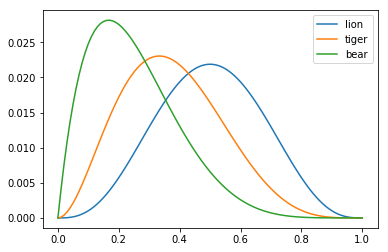

In [37]:
import thinkbayes as tb
import matplotlib.pyplot as plt

eng_species = ["lion", "tiger", "bear"]

def plot_dist(dist, c=None):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y, c=c)

def beta_mle(positive, negative, title):
    beta = tb.Beta()
    beta.Update((positive, negative))
    pmf = beta.MakePmf()
    print(title, "MLE:", pmf.MaximumLikelihood()*100, "%")
    print(pmf.Prob(0), pmf.Mean())
    plot_dist(pmf)
    
beta_mle(3, 3, "獅子")
beta_mle(2, 4, "老虎")
beta_mle(1, 5, "熊")
plt.legend(eng_species)
plt.show()

p_lion, p_tiger 和 p_bear 的最大似然估計分別是 50%、33% 跟 17%。但有兩個問題：
 
1. 我們隱含的認為每個物種的先驗是由 0 到 1 的均勻分佈，但我們知道總共有三個物種，所以正確的先驗應該是的平均值 1/3，而且任何物種 100% 的似然性應該是 0。
1. 每個物種的分佈不是獨立的，因為出現的機率加總要為 1。為了捕捉到這個相關性，我們需要對這三個物種計算聯合分佈。

我們可以用 Dirichlet 分佈來解決以上兩個問題（參考 http://en.wikipedia.org/wiki/Dirichlet_distribution ）。相同的，我們用 Beta 分佈描述一個有偏差的硬幣，我們也可以用 Dirichlet 分佈來描述 p_lion、p_tiger 和 p_bear 的聯合分佈。

Dirichlet 分佈是 Beta 分佈的多維一般化的版本。相較於只有兩種可能的結果，像是「正面」及「反面」，Dirichlet 分佈可以處理兩個以上的結果：本例就是三個物種。若有 n 種結果，Dirichlet 分佈用 n 個參數來描述，寫作 α1 到 αn。

這邊是 thinkbayes.py 中 Dirichlet 類別的定義：

<pre>
class Dirichlet(object):
    def __init__(self, n):
        # n 表示有多少維度
        self.n = n
        
        # 將每個維度的參數初始化成 1，這邊用 numpy array 儲存參數可以有 numpy 陣列操作的好處
        self.params = numpy.ones(n, dtype=numpy.int)
</pre>

給定一個 Dirichlet 分佈，每種物種的邊際分佈（marginal distribution）服從一個 Beta 分佈，我們可以如下計算：

<pre>
# class Dirichlet(object):

def MarginalBeta(self, i):
    # i 是第幾個參數的邊際分佈
    
    # alpha0: 所有參數的總和
    alpha0 = self.params.sum()
    
    # alpha 是特定種類的參數
    alpha = self.params[i]
    return Beta(alpha, alpha0-alpha)
</pre>

此範例的每個物種的先驗邊際分佈是 Beta(1, 2)。我們可以用下方的方式計算先驗分佈的平均值：

In [39]:
species = ["獅子", "老虎", "熊"]
dirichlet = tb.Dirichlet(3)
for i in range(3):
    beta = dirichlet.MarginalBeta(i)
    print(species[i], beta.Mean())

獅子 0.3333333333333333
老虎 0.3333333333333333
熊 0.3333333333333333


如預期的每個物種的平均出現機率是 1/3。

要更新 Dirichlet 分佈，我們將觀察到的資料到加到參數上如下：

<pre>
def Update(self, data):
    m = len(data)
    self.params[:m] += data
</pre>

資料是與參數順序相同的的種類數量，所以此例子應該分別是獅子、老虎和熊的數量。資料有可能比參數少；也就是有些種類還沒觀察到。

下方程式碼是用觀察到的資料更新 Dirichlet 分佈，並且計算每一個參數的後驗邊際分佈。

獅子 0.4444444340844438
老虎 0.3333333706573365
熊 0.22232593076561627


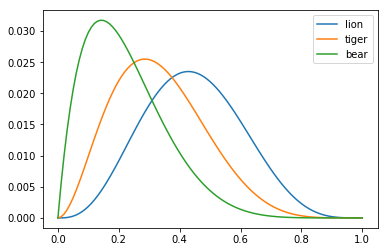

In [40]:
data = [3, 2, 1]
dirichlet.Update(data)
for i in range(3):
    beta = dirichlet.MarginalBeta(i)
    pmf = beta.MakePmf()
    print(species[i], pmf.Mean())
    plot_dist(pmf)
    
plt.legend(eng_species)
plt.show()

上圖為每個種類的後驗邊際分佈 pmf 。 後驗的平均分別是 44%、33% 和 22%。